<a href="https://colab.research.google.com/github/OnlySem/ITMO/blob/main/%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорты библиотек

In [1]:
!pip install --upgrade matplotlib > None
!pip install -U scikit-learn > None

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.cbook import boxplot_stats
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.datasets import load_diabetes, load_breast_cancer, make_classification, load_iris
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import f1_score, fbeta_score

%matplotlib inline

# Информация о базе данных

Набор данных состоит из анонимных данных о заработной плате научных сотрудников различных стран по годам.

In [3]:
path = 'https://raw.githubusercontent.com/OnlySem/ITMO/refs/heads/main/DataScience_salaries_2024.csv'
data = pd.read_csv(path)
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2021,MI,FT,Data Scientist,30400000,CLP,40038,CL,100,CL,L
1,2021,MI,FT,BI Data Analyst,11000000,HUF,36259,HU,50,US,L
2,2020,MI,FT,Data Scientist,11000000,HUF,35735,HU,50,HU,L
3,2021,MI,FT,ML Engineer,8500000,JPY,77364,JP,50,JP,S
4,2022,SE,FT,Lead Machine Learning Engineer,7500000,INR,95386,IN,50,IN,L


In [4]:
data.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

In [5]:
data.shape

(14838, 11)

In [6]:
data.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,14838.000000,1.483800e+04,14838.000000,14838.000000
mean,2023.138900,1.650227e+05,149874.718763,32.760480
std,0.700799,3.562354e+05,69009.181349,46.488278
min,2020.000000,1.400000e+04,15000.000000,0.000000
25%,2023.000000,1.021000e+05,102000.000000,0.000000
50%,2023.000000,1.422000e+05,141300.000000,0.000000
75%,2024.000000,1.875000e+05,185900.000000,100.000000
max,2024.000000,3.040000e+07,800000.000000,100.000000


In [7]:
data.dtypes

,0
work_year,int64
experience_level,object
employment_type,object
job_title,object
salary,int64
salary_currency,object
salary_in_usd,int64
employee_residence,object
remote_ratio,int64
company_location,object


База данных заполнена полностью, пропусков нет

In [8]:
data.isna().sum()

,0
work_year,0
experience_level,0
employment_type,0
job_title,0
salary,0
salary_currency,0
salary_in_usd,0
employee_residence,0
remote_ratio,0
company_location,0


In [9]:
cat_cols = data.select_dtypes(include='object')
num_col = data.select_dtypes(exclude='object')

База данных содержит 4 типа квалификации сотрудников, 4 типа трудоустройства сотрудников, 153 должности, 23 типа валюты заработной платы, 88 страны проживания сотрудников, 77 стран расположения компаний и 3 типа размера компании.

In [10]:
cat_cols.describe()

,experience_level,employment_type,job_title,salary_currency,employee_residence,company_location,company_size
count,14838,14838,14838,14838,14838,14838,14838
unique,4,4,153,23,88,77,3
top,SE,FT,Data Engineer,USD,US,US,M
freq,9696,14772,3162,13682,12926,12975,13674


тип трудоустройства
FT - Full-time, PT - part-time, CT - contract, FL - freelance

In [11]:
cat_cols['employment_type'].value_counts()

,count
employment_type,
FT,14772
PT,27
CT,26
FL,13


# Визуализация данных

In [12]:
for c in cat_cols:
    le = LabelEncoder()
    le.fit(cat_cols[c])
    cat_cols[c] = le.transform(cat_cols[c])

По тепловой карте видна некоторая зависимость зарплаты сотрудника в USD от: опыта сотрудника, должности, метса жительства сотрудника и страны компании.

<Axes: >

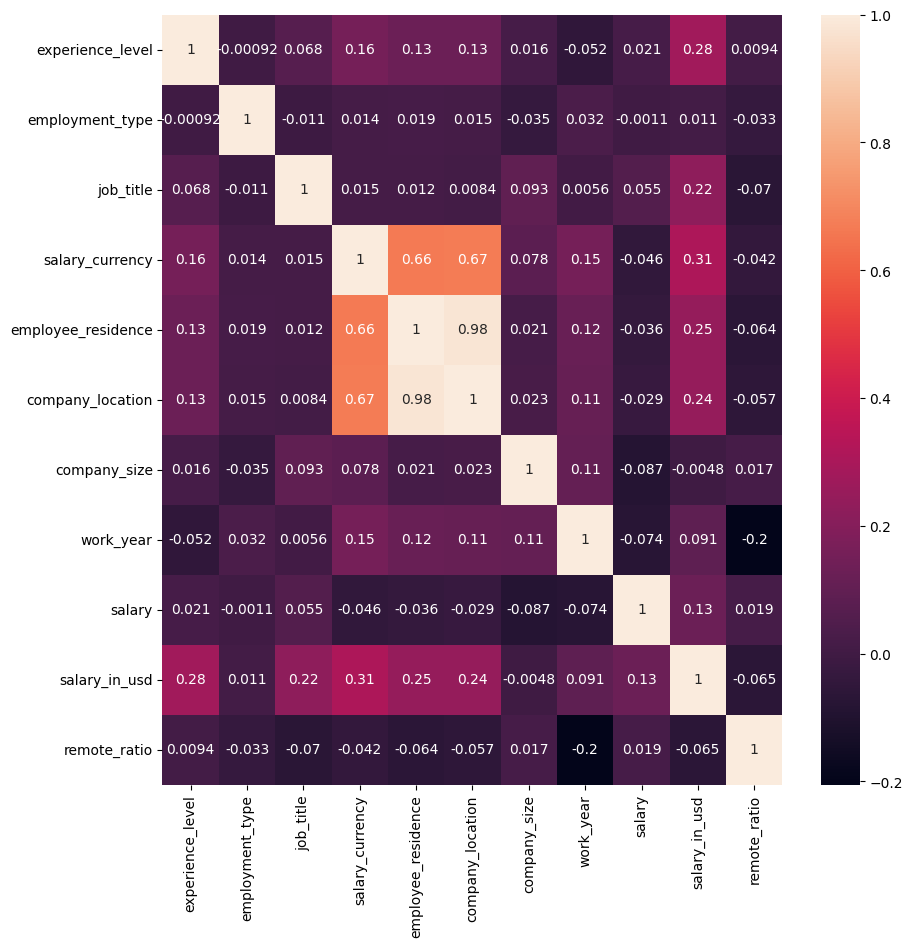

In [13]:
hm_data = pd.concat([cat_cols, num_col], axis=1)
fig, axes = plt.subplots(figsize=(10, 10))
sns.heatmap(hm_data.corr(), annot=True)

## Средняя заработной платы в зависимости от опыта сотрудника

In [14]:
data['experience_level'].value_counts()

,count
experience_level,
SE,9696
MI,3553
EN,1148
EX,441


EN - Junior, MI - Mid-level, SE - Senior, EX - Expert

Text(0.5, 1.0, 'experience_level')

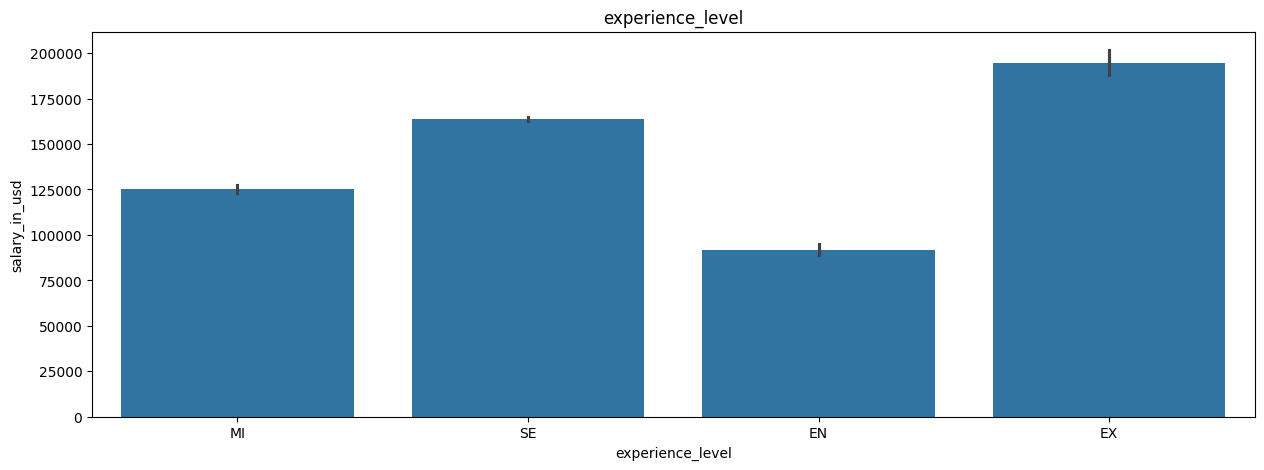

In [15]:
fig, axes = plt.subplots(figsize=(15, 5))
sns.barplot(data, x = 'experience_level', y = 'salary_in_usd')
axes.set_title('experience_level')

среднее значение зарплат в зависимости от опыта сотрудника по годам

In [16]:
data.groupby(['experience_level','work_year'])['salary_in_usd'].mean()

experience_level  work_year
EN                2020          69840.666667
                  2021          63463.065217
                  2022          80018.698276
                  2023          91166.310345
                  2024          98308.906188
EX                2020         179958.250000
                  2021         186128.000000
                  2022         188260.292683
                  2023         191314.194215
                  2024         203320.854167
MI                2020          91870.935484
                  2021          86818.390805
                  2022         102733.432961
                  2023         123821.311772
                  2024         136547.600294
SE                2020         138648.894737
                  2021         125989.746667
                  2022         147982.512753
                  2023         165421.026078
                  2024         168214.908784
Name: salary_in_usd, dtype: float64

In [17]:
Junior = data.loc[data['experience_level'] == 'EN']
Expert = data.loc[data['experience_level'] == 'EX']
Mid_level = data.loc[data['experience_level'] == 'MI']
Senior = data.loc[data['experience_level'] == 'SE']

Text(0.5, 1.0, 'Expert')

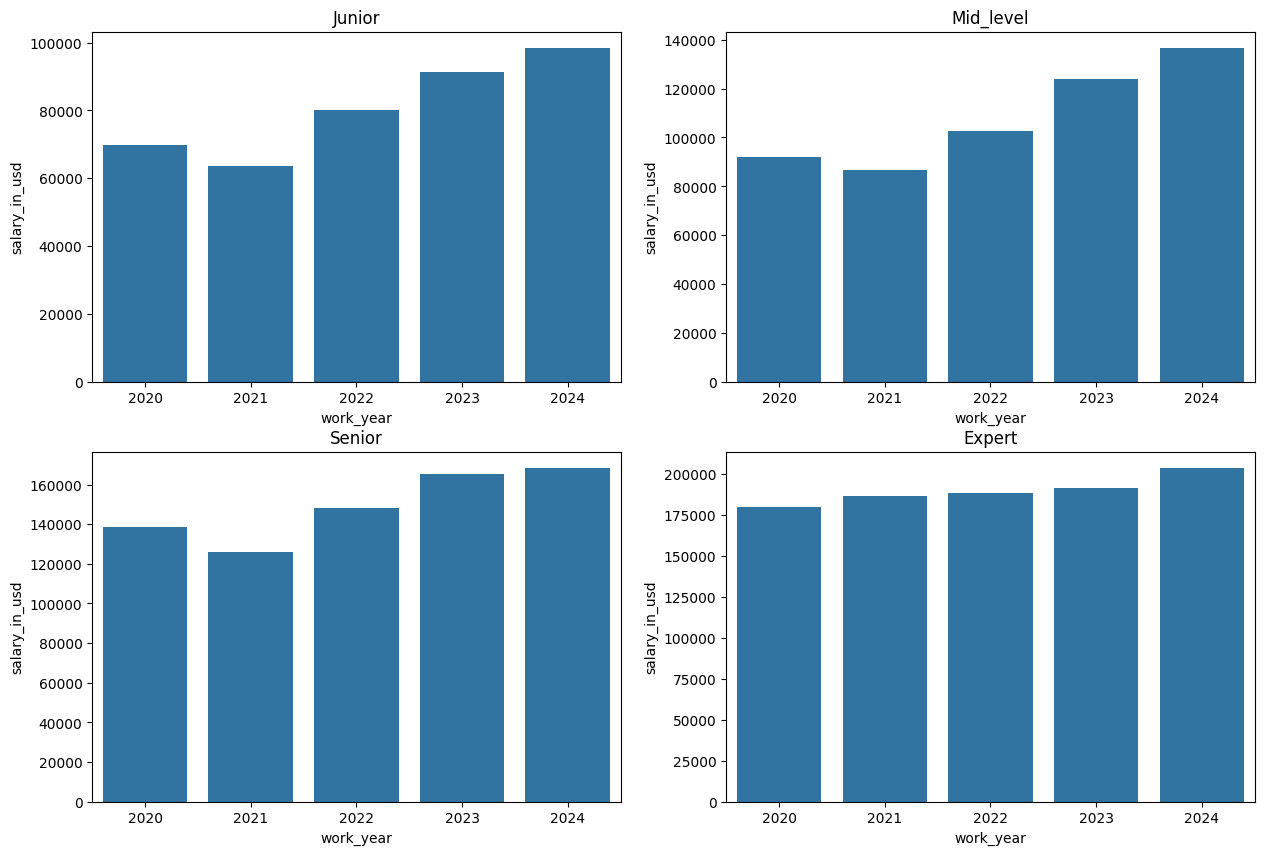

In [18]:
аfig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
sns.barplot(Junior.groupby('work_year')['salary_in_usd'].mean(), ax = axes[0, 0])
axes[0, 0].set_title('Junior')
sns.barplot(Mid_level.groupby('work_year')['salary_in_usd'].mean(), ax = axes[0, 1])
axes[0, 1].set_title('Mid_level')
sns.barplot(Senior.groupby('work_year')['salary_in_usd'].mean(), ax = axes[1, 0])
axes[1, 0].set_title('Senior')
sns.barplot(Expert.groupby('work_year')['salary_in_usd'].mean(), ax = axes[1, 1])
axes[1, 1].set_title('Expert')

Text(0.5, 1.0, 'Expert')

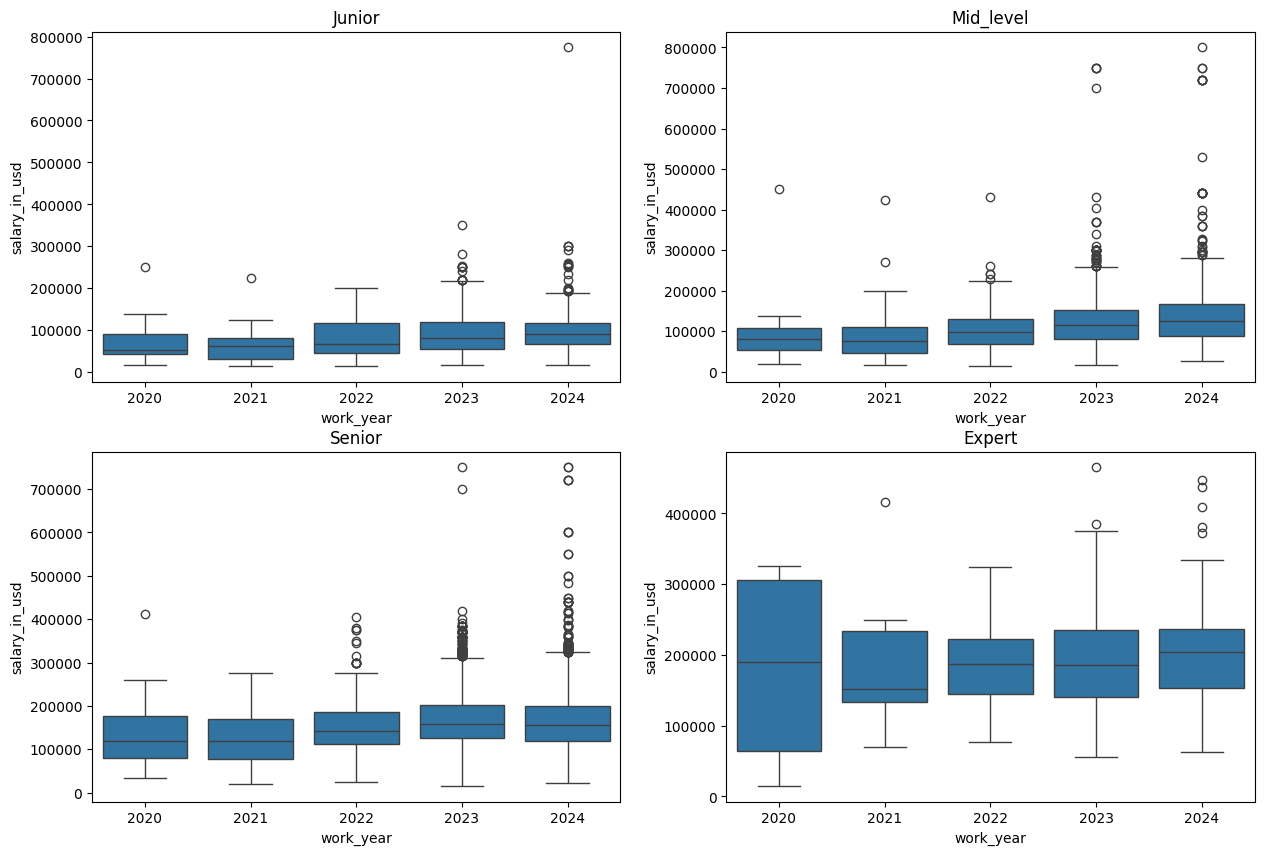

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
sns.boxplot(Junior, x = 'work_year', y = 'salary_in_usd', ax = axes[0, 0])
axes[0, 0].set_title('Junior')
sns.boxplot(Mid_level, x = 'work_year', y = 'salary_in_usd', ax = axes[0, 1])
axes[0, 1].set_title('Mid_level')
sns.boxplot(Senior, x = 'work_year', y = 'salary_in_usd', ax = axes[1, 0])
axes[1, 0].set_title('Senior')
sns.boxplot(Expert, x = 'work_year', y = 'salary_in_usd', ax = axes[1, 1])
axes[1, 1].set_title('Expert')

##Зависимость заработной платы сотрудников от размера компании

Text(0.5, 1.0, 'company_size')

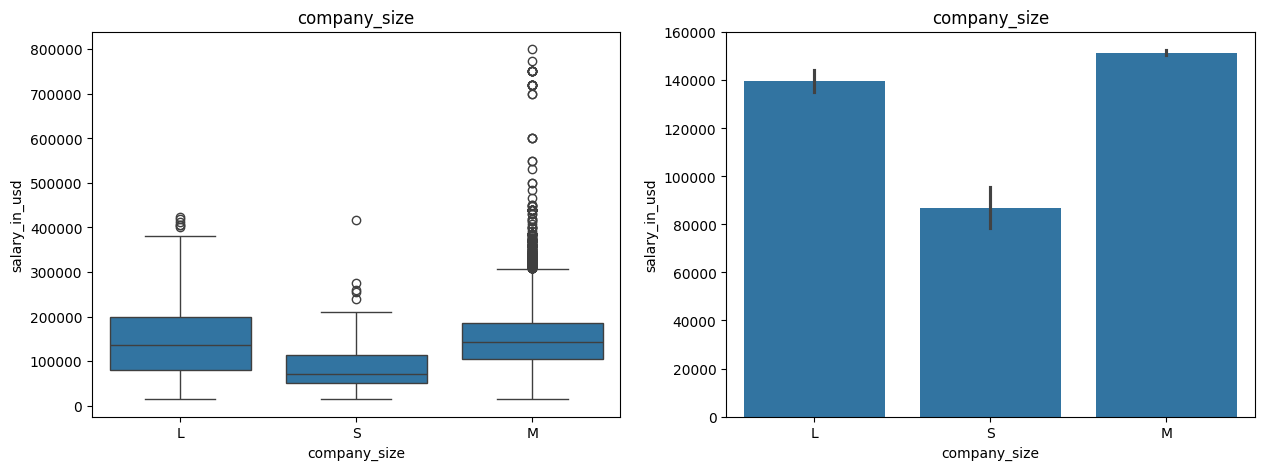

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.boxplot(data, x = 'company_size', y = 'salary_in_usd', ax = axes[0])
axes[0].set_title('company_size')
sns.barplot(data, x = 'company_size', y = 'salary_in_usd', ax = axes[1])
axes[1].set_title('company_size')

##Зависимость заработной платы от страны расположения компании

Text(0.5, 1.0, 'company_location')

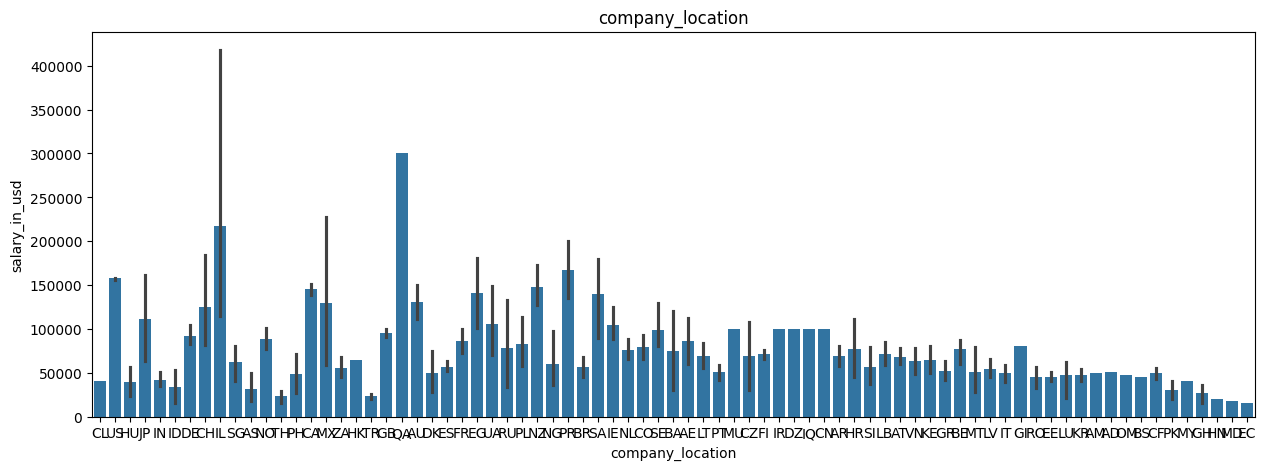

In [21]:
fig, axes = plt.subplots(figsize=(15, 5))
sns.barplot(data, x = 'company_location', y = 'salary_in_usd')
axes.set_title('company_location')

##Зависимость заработной платы от места жительства сотрудника

Text(0.5, 1.0, 'employee_residence')

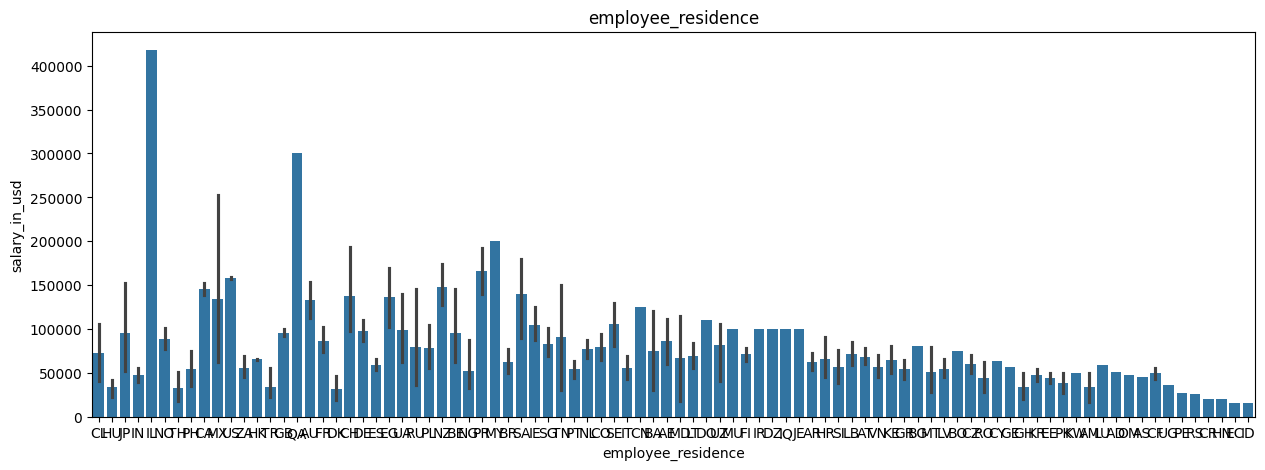

In [22]:
fig, axes = plt.subplots(figsize=(15, 5))
sns.barplot(data, x = 'employee_residence', y = 'salary_in_usd')
axes.set_title('employee_residence')

##Зависимость заработной платы от должности сотрудника

Text(0.5, 1.0, 'job_title')

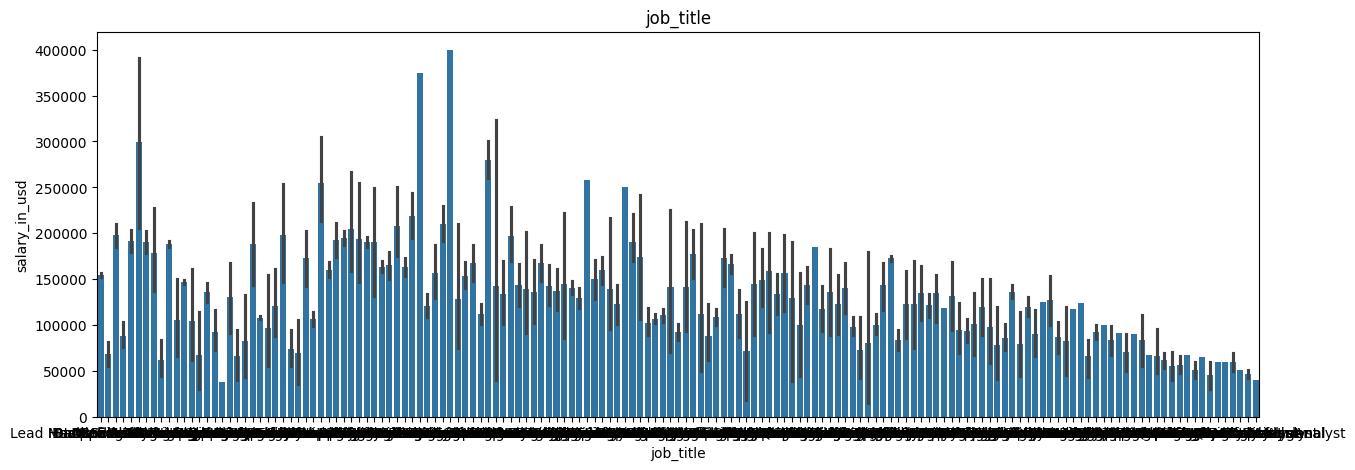

In [23]:
fig, axes = plt.subplots(figsize=(15, 5))
sns.barplot(data, x = 'job_title', y = 'salary_in_usd')
axes.set_title('job_title')

#

#Обработка данных

Для опыта сотрудников и размера компании применяем порядковое кодирование. EN - Junior, MI - Mid-level, SE - Senior, EX - Expert.


In [42]:
df = data.copy()

df['experience_level'] = df['experience_level'].replace('EN', 1)
df['experience_level'] = df['experience_level'].replace('MI', 2)
df['experience_level'] = df['experience_level'].replace('SE', 3)
df['experience_level'] = df['experience_level'].replace('EX', 4)

df['company_size'] = df['company_size'].replace('S', 1)
df['company_size'] = df['company_size'].replace('M', 2)
df['company_size'] = df['company_size'].replace('L', 3)

Столбецы с валютой заработной платы и заработной платой в определенной валюте считаю лишними переменными в базе данных, т.к есть обобщенный стоблец заработной платы в USD.



In [43]:
del df['salary_currency']
del df['salary']

Так же в связи с малым количеством данных в стоблце employment_type отличных от FT, удаляем данные.

In [44]:
df = df.drop(df[df['employment_type'] == 'PT'].index)
df = df.drop(df[df['employment_type'] == 'CT'].index)
df = df.drop(df[df['employment_type'] == 'FL'].index)
del df['employment_type']
df = df.reset_index()
del df['index']
df

,work_year,experience_level,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2021,2,Data Scientist,40038,CL,100,CL,3
1,2021,2,BI Data Analyst,36259,HU,50,US,3
2,2020,2,Data Scientist,35735,HU,50,HU,3
3,2021,2,ML Engineer,77364,JP,50,JP,1
4,2022,3,Lead Machine Learning Engineer,95386,IN,50,IN,3
...,...,...,...,...,...,...,...,...
14767,2022,1,Research Engineer,16455,RU,100,RU,2
14768,2022,2,Business Intelligence Developer,15000,GH,100,GH,2
14769,2020,4,Staff Data Analyst,15000,NG,0,CA,2
14770,2021,1,Machine Learning Developer,15000,TH,100,TH,3


Для должности работника применяем OneHotEncoder

In [27]:
ohe = OneHotEncoder()
res_jt = ohe.fit_transform(df['job_title'].to_numpy().reshape(-1, 1))
ohe_jt = pd.DataFrame(res_jt.toarray(), columns=ohe.get_feature_names_out())

так же применяем OneHotEncoder для места жительства сотрудника и страны расположения компании

In [28]:
res_er = ohe.fit_transform(df['employee_residence'].to_numpy().reshape(-1, 1))
ohe_er = pd.DataFrame(res_er.toarray(), columns=ohe.get_feature_names_out())

res_cl = ohe.fit_transform(df['company_location'].to_numpy().reshape(-1, 1))
ohe_cl = pd.DataFrame(res_cl.toarray(), columns=ohe.get_feature_names_out())

In [29]:
df_test = pd.concat([df, ohe_jt, ohe_cl, ohe_er], axis=1)
del df_test['job_title']
del df_test['employee_residence']
del df_test['company_location']
df_test.head()

,work_year,experience_level,salary_in_usd,remote_ratio,company_size,x0_AI Architect,x0_AI Developer,x0_AI Engineer,x0_AI Product Manager,x0_AI Programmer,...,x0_SI,x0_TH,x0_TN,x0_TR,x0_UA,x0_UG,x0_US,x0_UZ,x0_VN,x0_ZA
0,2021,2,40038,100,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,2,36259,50,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020,2,35735,50,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021,2,77364,50,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022,3,95386,50,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##Разделение признаков на тренировочные и тестовые

Данные с кодированием OneHotEncoder

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    df_test.drop(columns='salary_in_usd'),
    df_test['salary_in_usd'],
    random_state=2024,
    test_size=0.3
)

данные с кодированием признаков LabelEncoder

In [53]:
for c in df:
    le = LabelEncoder()
    le.fit(df[c])
    df[c] = le.transform(df[c])

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns='salary_in_usd'),
    df['salary_in_usd'],
    random_state=2024,
    test_size=0.3
)

##Масштабирование признаков

In [54]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)
X_train_scaled.head()

,work_year,experience_level,job_title,employee_residence,remote_ratio,company_location,company_size
0,-0.205458,0.547840,0.472835,-3.354409,-0.702052,-3.395977,-0.198974
1,-0.205458,2.056809,0.792558,0.359981,1.451059,0.356041,-0.198974
2,-0.205458,0.547840,-0.486333,0.359981,1.451059,0.356041,-0.198974
3,-0.205458,0.547840,0.414704,0.359981,-0.702052,0.356041,-0.198974
4,-0.205458,0.547840,2.100515,0.359981,-0.702052,0.356041,-0.198974


In [55]:
ridge = Ridge(alpha=1)
ridge.fit(X_train_scaled, y_train)
y_preds = ridge.predict(X_test_scaled)

print(f'RMSE Ridge: {mean_squared_error(y_test, y_preds, squared=False)}')


RMSE Ridge: 569.6470275154484


In [56]:
ridge = Ridge(alpha=1)
ridge.fit(X_train, y_train)
y_preds = ridge.predict(X_test)

print(f'RMSE Ridge: {mean_squared_error(y_test, y_preds, squared=False)}')

RMSE Ridge: 569.6460173004014


In [57]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train_scaled, y_train)
y_preds = clf.predict(X_test_scaled)
print(f'RMSE Ridge: {mean_squared_error(y_test, y_preds, squared=False)}')


RMSE Ridge: 668.0096602124734


In [58]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_preds = clf.predict(X_test)
print(f'RMSE Ridge: {mean_squared_error(y_test, y_preds, squared=False)}')


RMSE Ridge: 670.0693008976125
